In [220]:
import numpy as np
import pandas
from matplotlib import pyplot as plt
from scipy.interpolate import interp1d

import sys
sys.path.append("../../") # go to parent dir
import plot_utils

In [177]:
def CRe_dNdE_dampe(E):
    # https://www.nature.com/articles/nature24475.pdf
    N = 1.62e-1 #m−2 s−1 sr−1 TeV−1
    g1 = -3.09
    g2 = -3.92
    Eb = 0.914 # TeV
    delta = 0.1
    return N * (E/0.1)**g1 * (1 + (E/Eb)**((g1 - g2)/delta))**(-delta)

def CRe_dNdE_dampe_hard(E):
    Ebr2 = 3.4 # TeV - position of the second break
    N = CRe_dNdE_dampe(Ebr2)
    g3 = -3.
    return np.heaviside(Ebr2 - E, 0.5) * CRe_dNdE_dampe(E) + N * np.heaviside(E - Ebr2, 0.5) * (E / Ebr2)**g3

def CRe_dNdE_hess2009(E):
    # https://arxiv.org/pdf/0905.0105.pdf
    N = 1.5e-4 # TeV-1 m-2 s-1 sr-1
    Eb = 0.9 # TeV
    g1 = -3.0
    g2 = -4.1
    return N * (np.heaviside(E - Eb, 0.5) * (E / Eb)**g2 + np.heaviside(Eb - E, 0.5) * (E / Eb)**g1)

def CRe_dNdE_hess2017(E):
    # https://pdfs.semanticscholar.org/26b3/e7071f5b0e912759e1660060e28fa7cfa9af.pdf
    N = 1.04e-4 # TeV-1 m-2 s-1 sr-1
    Eb = 0.94 # TeV
    g1 = -3.04
    g2 = -3.78
    #g2 = -3.3
    return N * (np.heaviside(E - Eb, 0.5) * (E / Eb)**g2 + np.heaviside(Eb - E, 0.5) * (E / Eb)**g1)

# choice of the CRe spectrum
CRe_dNdE = CRe_dNdE_dampe_hard

def CRp_dNdE(E):
    N = 1.e-1 # TeV-1 m-2 s-1 sr-1
    g1 = -2.7
    Eb = 1. # TeV
    return N * (E / Eb)**g1

def FB_dNdE(E):
    N = 1.3e-5 # TeV-1 m-2 s-1 sr-1
    g1 = -2.
    Eb = 1. # TeV
    return N * (E / Eb)**g1



In [158]:
plot_utils.setup_figure_pars();
save_plots = 1
plt.rcParams['legend.fontsize'] = 14
plt.rcParams['figure.figsize'] = [8, 6]
plots_folder = '../plots/'

# Flux without rejection

In [266]:
# 6 bins per decade
Ebins = np.logspace(-0.5, 1.5, 13)
Ec = np.sqrt(Ebins[1:] * Ebins[:-1])
dE = Ebins[1:] - Ebins[:-1]
if 0:
    Aeff = 1.e5 # m2
else:
    # use the std zeta BDT aeff
    fn = '../data/Stefan_Ohm_Figure2.18b_Aeff.csv'
    data = pandas.read_csv(fn, comment='#')
    data_Es = data['E (TeV)']
    data_aeff_values = data['Aeff (m^2)']
    Aeff_func = interp1d(data_Es, data_aeff_values, kind='linear', fill_value="extrapolate")
    Aeff = Aeff_func(Ec)

    
t = 1000. * 3600. # 1000 hours
Om = np.pi * np.deg2rad(3.5/2)**2 # HESS FOV
#Om = np.pi * np.deg2rad(3)**2 # MST FOV
Ne0 = CRe_dNdE(Ec) * dE * Aeff * t * Om
Np0 = CRp_dNdE(Ec) * dE * Aeff * t * Om
Q0 =  Ne0 / np.sqrt(Np0 + Ne0)
print('index\t Energy\t electrons\t protons\t S/N')
for i in range(len(Ec)):
    print('%i\t %.1f\t %.3e\t %.3e\t %.3f' % (i, Ec[i], Ne0[i], Np0[i], Q0[i]))

index	 Energy	 electrons	 protons	 S/N
0	 0.4	 3.367e+05	 1.759e+08	 25.363
1	 0.6	 1.895e+05	 1.152e+08	 17.644
2	 0.8	 1.024e+05	 7.478e+07	 11.833
3	 1.2	 4.471e+04	 4.666e+07	 6.542
4	 1.8	 1.647e+04	 2.721e+07	 3.156
5	 2.6	 5.908e+03	 1.559e+07	 1.496
6	 3.8	 2.245e+03	 8.473e+06	 0.771
7	 5.6	 1.071e+03	 4.535e+06	 0.503
8	 8.3	 5.342e+02	 2.538e+06	 0.335
9	 12.1	 2.416e+02	 1.288e+06	 0.213
10	 17.8	 1.096e+02	 6.557e+05	 0.135
11	 26.1	 5.010e+01	 3.363e+05	 0.086


# Fermi bubbles flux

In [267]:
Om_FB = 4. * np.deg2rad(1.)**2 # 4 square degrees in radians
Exp_FB = 5.e10 # m2 s - average exposure for hess1u data inside FB ROI
if 0:
    Rg_FB = 0.6
    Rp_FB = 0.001
else:
    Rg_FB = 0.84
    Rp_FB = 0.02
    
Ng_FB = Rg_FB * FB_dNdE(Ec) * Om_FB * Exp_FB * dE
Np_FB = Rp_FB * CRp_dNdE(Ec) * Om_FB * Exp_FB * dE
Q_FB = Ng_FB / np.sqrt(Ng_FB + Np_FB)
Q_FB_tot = np.sum(Ng_FB[3:]) / np.sqrt(np.sum((Ng_FB + Np_FB)[3:]))
print('Average obs time: %.2f hr' % (Exp_FB/1.e5/3600.))
print('Total signif above 1 TeV: %.2f' % Q_FB_tot)
print('index\t Energy\t FB gammas\t FB protons\t S/N')
for i in range(len(Ec)):
    print('%i\t %.1f\t %.3e\t %.3e\t %.3f' % (i, Ec[i], Ng_FB[i], Np_FB[i], Q_FB[i]))

Average obs time: 138.89 hr
Total signif above 1 TeV: 2.41
index	 Energy	 FB gammas	 FB protons	 S/N
0	 0.4	 6.705e+02	 2.404e+05	 1.366
1	 0.6	 4.568e+02	 1.252e+05	 1.289
2	 0.8	 3.112e+02	 6.519e+04	 1.216
3	 1.2	 2.120e+02	 3.395e+04	 1.147
4	 1.8	 1.445e+02	 1.768e+04	 1.082
5	 2.6	 9.842e+01	 9.209e+03	 1.020
6	 3.8	 6.705e+01	 4.796e+03	 0.961
7	 5.6	 4.568e+01	 2.498e+03	 0.906
8	 8.3	 3.112e+01	 1.301e+03	 0.853
9	 12.1	 2.120e+01	 6.774e+02	 0.802
10	 17.8	 1.445e+01	 3.528e+02	 0.754
11	 26.1	 9.842e+00	 1.837e+02	 0.707


# Optimistic scenario
60% electron rejection
0.1% proton rejection
3e5 m2 Aeff

In [268]:
# optimistic case
t_opt = 2000. * 3600. # 1000 hours
Re_opt = 0.6
Rp_opt = 0.001
Aeff_opt = 3.e5 # m^2
Ne_opt = Re_opt * CRe_dNdE(Ec) * dE * Aeff_opt * t * Om
Np_opt = Rp_opt * CRp_dNdE(Ec) * dE * Aeff_opt * t * Om
Q_opt =  Ne_opt / np.sqrt(Np_opt + Ne_opt)
print('index\t Energy\t electrons\t protons\t S/N')
for i in range(len(Ec)):
    print('%i\t %.1f\t %.3e\t %.3e\t %.3f' % (i, Ec[i], Ne_opt[i], Np_opt[i], Q_opt[i]))


index	 Energy	 electrons	 protons	 S/N
0	 0.4	 7.171e+05	 6.244e+05	 619.153
1	 0.6	 3.210e+05	 3.252e+05	 399.344
2	 0.8	 1.391e+05	 1.694e+05	 250.515
3	 1.2	 5.071e+04	 8.820e+04	 136.048
4	 1.8	 1.668e+04	 4.593e+04	 66.661
5	 2.6	 5.441e+03	 2.392e+04	 31.755
6	 3.8	 1.980e+03	 1.246e+04	 16.481
7	 5.6	 9.192e+02	 6.488e+03	 10.680
8	 8.3	 4.267e+02	 3.379e+03	 6.916
9	 12.1	 1.980e+02	 1.760e+03	 4.476
10	 17.8	 9.192e+01	 9.165e+02	 2.895
11	 26.1	 4.267e+01	 4.773e+02	 1.871


# Thesis from Manuel Kraus (2018)

In [269]:
# Manuel Kraus rejection BDT
fn = '../data/MK_thesis_CRe_Q.csv'
MK_data = pandas.read_csv(fn, comment='#')

Re_MK = 0.02
Rp_MK = 3.e-7
#print(Re / np.sqrt(Rp))
Ne_MK = Re_MK*Ne0
Np_MK = Rp_MK*Np0
Q_MK = Ne_MK / np.sqrt(Np_MK + Ne_MK)
print('index\t Energy\t electrons\t protons\t S/N')
for i in range(len(Ec)):
    print('%i\t %.1f\t %.3e\t %.3e\t %.3f' % (i, Ec[i], Ne_MK[i], Np_MK[i], Q_MK[i]))


index	 Energy	 electrons	 protons	 S/N
0	 0.4	 6.734e+03	 5.277e+01	 81.741
1	 0.6	 3.790e+03	 3.455e+01	 61.286
2	 0.8	 2.048e+03	 2.243e+01	 45.008
3	 1.2	 8.942e+02	 1.400e+01	 29.671
4	 1.8	 3.294e+02	 8.163e+00	 17.928
5	 2.6	 1.182e+02	 4.676e+00	 10.662
6	 3.8	 4.490e+01	 2.542e+00	 6.519
7	 5.6	 2.142e+01	 1.360e+00	 4.487
8	 8.3	 1.068e+01	 7.615e-01	 3.158
9	 12.1	 4.833e+00	 3.865e-01	 2.115
10	 17.8	 2.192e+00	 1.967e-01	 1.418
11	 26.1	 1.002e+00	 1.009e-01	 0.954


## Manuel Kraus electrons from the thesis

In [270]:
E_MK = np.sqrt(MK_data['Emin'] * MK_data['Emax'])
dE_MK = MK_data['Emax'] - MK_data['Emin']
Ne_MK_th = MK_data['electrons']
Ne_MK_est = CRe_dNdE(E_MK) * dE_MK * Aeff_func(E_MK) * t * Om
print('index\t Energy\t e (thesis)\t e (flux) - no rejection')
for i in range(len(E_MK)):
    print('%i\t %.2f\t %.3e\t %.3e' % (i, E_MK[i], Ne_MK_th[i], Ne_MK_est[i]))

index	 Energy	 e (thesis)	 e (flux) - no rejection
0	 0.32	 1.333e+03	 1.313e+05
1	 0.37	 1.206e+04	 1.689e+05
2	 0.45	 2.065e+04	 1.283e+05
3	 0.54	 1.644e+04	 1.049e+05
4	 0.64	 1.268e+04	 5.723e+04
5	 0.76	 1.172e+04	 5.717e+04
6	 0.90	 7.313e+03	 3.721e+04
7	 1.04	 3.856e+03	 1.930e+04
8	 1.22	 5.349e+03	 2.340e+04
9	 1.56	 3.955e+03	 1.734e+04
10	 2.03	 1.589e+03	 7.406e+03
11	 2.63	 9.510e+02	 4.006e+03
12	 3.42	 3.660e+02	 1.901e+03
13	 4.63	 3.100e+02	 1.387e+03
14	 6.02	 1.090e+02	 4.461e+02
15	 7.27	 8.900e+01	 3.349e+02
16	 8.72	 7.600e+01	 2.156e+02
17	 11.11	 9.300e+01	 2.368e+02
18	 14.87	 6.000e+01	 1.093e+02
19	 19.34	 4.000e+01	 6.204e+01
20	 25.69	 2.500e+01	 4.181e+01
21	 34.64	 8.000e+00	 2.021e+01


# Cut with standard BDT

In [271]:
# standard cut zeta BDT
Re = 0.84
Rp = 0.02
#print(Re / np.sqrt(Rp))
Ne_BDT = Re*Ne0
Np_BDT = Rp*Np0
Q_BDT = Ne_BDT / np.sqrt(Np_BDT + Ne_BDT)
print('index\t Energy\t electrons\t protons\t S/N')
for i in range(len(Ec)):
    print('%i\t %.1f\t %.3e\t %.3e\t %.3f' % (i, Ec[i], Ne_BDT[i], Np_BDT[i], Q_BDT[i]))


index	 Energy	 electrons	 protons	 S/N
0	 0.4	 2.828e+05	 3.518e+06	 145.072
1	 0.6	 1.592e+05	 2.304e+06	 101.437
2	 0.8	 8.601e+04	 1.496e+06	 68.394
3	 1.2	 3.755e+04	 9.332e+05	 38.116
4	 1.8	 1.383e+04	 5.442e+05	 18.519
5	 2.6	 4.963e+03	 3.117e+05	 8.820
6	 3.8	 1.886e+03	 1.695e+05	 4.555
7	 5.6	 8.995e+02	 9.070e+04	 2.972
8	 8.3	 4.487e+02	 5.077e+04	 1.983
9	 12.1	 2.030e+02	 2.577e+04	 1.260
10	 17.8	 9.207e+01	 1.311e+04	 0.801
11	 26.1	 4.208e+01	 6.725e+03	 0.512


# Thesis by Kathrin Egberts

In [272]:
fn = '../data/KE_thesis_CRe_Q.csv'
KE_data = pandas.read_csv(fn, comment='#')
E_KE = np.sqrt(KE_data['Emin'] * KE_data['Emax'])
dE_KE = (KE_data['Emax'] - KE_data['Emin'])
Ne_KE = KE_data['electrons']
Np_KE = KE_data['protons']
Q_KE = Ne_KE / np.sqrt(Np_KE + Ne_KE)

print('index\t Energy\t electrons\t protons\t S/N')
for i in range(len(E_KE)):
    print('%i\t %.1f\t %.3e\t %.3e\t %.3f' % (i, E_KE[i], Ne_KE[i], Np_KE[i], Q_KE[i]))


index	 Energy	 electrons	 protons	 S/N
0	 0.7	 3.490e+03	 6.934e+03	 34.183
1	 0.9	 2.230e+03	 4.145e+03	 27.930
2	 1.2	 1.480e+03	 2.901e+03	 22.360
3	 1.6	 7.280e+02	 1.951e+03	 14.065
4	 2.0	 4.430e+02	 1.086e+03	 11.329
5	 2.6	 1.680e+02	 7.440e+02	 5.563
6	 3.4	 6.000e+01	 4.240e+02	 2.727
7	 5.1	 9.000e+01	 3.480e+02	 4.300
8	 9.8	 3.600e+01	 2.310e+02	 2.203


# Checks of KE electron and proton numbers in the thesis

In [273]:
t_KE = 239 * 3600 # exposure
Om_KE = np.pi * np.deg2rad(3/2)**2 # HESS FOV
#print('%.3g' % (Aeff * t_KE * Om_KE))
if 0:
    acc_KE = Aeff * t_KE * Om_KE
else:
    acc_KE = 8.5e7 # page 57 of KE thesis
#Ne_est = CRe_dNdE(E_KE) * dE_KE * acc_KE
if 0:
    Re_KE = 0.96
    Rp_KE = 0.0072
else:
    Re_KE = 0.6
    Rp_KE = 0.001

fn = '../data/Kathrin_Egberts_Figure3.17_Aeff.csv'
KE_aeff_data = pandas.read_csv(fn, comment='#')
KE_aeff_Es = KE_aeff_data['E (TeV)']
KE_aeff_values = KE_aeff_data['Aeff (10^3 m^2)'] * 1.e3
KE_aeff = interp1d(KE_aeff_Es, KE_aeff_values, kind='linear', fill_value="extrapolate")

Ne_KE_est = Re_KE * CRe_dNdE(E_KE) * dE_KE * KE_aeff(E_KE) * t_KE * Om_KE
Np_KE_est = Rp_KE * CRp_dNdE(E_KE) * dE_KE * KE_aeff(E_KE) * t_KE * Om_KE
Q_KE_est = Ne_KE_est / np.sqrt(Np_KE_est + Ne_KE_est)

t1000 = 1000. * 3600.
Ne0_KE = CRe_dNdE(Ec) * dE * KE_aeff(Ec) * t1000 * Om
Np0_KE = CRp_dNdE(Ec) * dE * KE_aeff(Ec) * t1000 * Om

Q_KE_est_1000 = Re_KE*Ne0_KE / np.sqrt(Re_KE*Ne0_KE + Rp_KE*Np0_KE)

print('index\t Energy\t KE_e\t\t KE_e(est)\t KE_p\t\t KE_p(est)')
for i in range(len(E_KE)):
    print('%i\t %.1f\t %.2e\t %.2e\t %.2e\t %.2e\t' % (i, E_KE[i], Ne_KE[i], Ne_KE_est[i], Np_KE[i], Np_KE_est[i]))


index	 Energy	 KE_e		 KE_e(est)	 KE_p		 KE_p(est)
0	 0.7	 3.49e+03	 1.84e+03	 6.93e+03	 2.06e+03	
1	 0.9	 2.23e+03	 1.08e+03	 4.14e+03	 1.40e+03	
2	 1.2	 1.48e+03	 1.07e+03	 2.90e+03	 1.82e+03	
3	 1.6	 7.28e+02	 4.53e+02	 1.95e+03	 1.09e+03	
4	 2.0	 4.43e+02	 2.63e+02	 1.09e+03	 8.53e+02	
5	 2.6	 1.68e+02	 1.50e+02	 7.44e+02	 6.63e+02	
6	 3.4	 6.00e+01	 7.05e+01	 4.24e+02	 4.28e+02	
7	 5.1	 9.00e+01	 6.49e+01	 3.48e+02	 4.44e+02	
8	 9.8	 3.60e+01	 2.62e+01	 2.31e+02	 2.18e+02	


In [274]:
Om

0.002930763034982043

In [275]:
fn = '../data/calet_cre_data.csv'
calet_data = pandas.read_csv(fn, comment='#')

calet_data.columns

Index(['Emin', 'Emax', 'Ecenter', 'Flux', 'Flux_stat_min', 'Flux_stat_max',
       'Flux_syst_min', 'Flux_syst_max', 'Flux_factor', 'Sigma_BDT_min',
       'Sigma_BDT_max', 'strig', 'dnorm', 'dtrk', 'dch', 'dID', 'dMC'],
      dtype='object')

# Space telescope measurement

In [276]:
# Calet
if 0:
    # https://indico.cern.ch/event/264551/contributions/588760/attachments/469864/650754/TeVPA-2013-torii.pdf
    Exp_calet = 220 * 24 * 3600 # 220 m2 sr days, 
else:
    # https://journals.aps.org/prl/pdf/10.1103/PhysRevLett.120.261102
    t_calet = 15811 * 3600 
    #Acc_calet = 1.04 # m^2 sr - this is what is claimed in the paper, but at higher 
    Acc_calet = 0.2 # m^2 sr - similar to dampe?
    Exp_calet = Acc_calet * t_calet
Ne_calet = CRe_dNdE(Ec) * dE * Exp_calet
Q_calet = np.sqrt(Ne_calet)

# calet raw data
fn = '../data/calet_cre_data.csv'
calet_data = pandas.read_csv(fn, comment='#')

TeV2GeV = 1000.
Ec_calet = calet_data['Ecenter'] / TeV2GeV
calet_dNdE = calet_data['Flux'] * calet_data['Flux_factor'] * TeV2GeV
calet_dNdE_err_low = np.sqrt(calet_data['Flux_stat_min']**2 + calet_data['Flux_syst_min']**2)
calet_dNdE_err_high = np.sqrt(calet_data['Flux_stat_max']**2 + calet_data['Flux_syst_max']**2)
calet_dNdE_err_low *= calet_data['Flux_factor'] * TeV2GeV
calet_dNdE_err_high *= calet_data['Flux_factor'] * TeV2GeV


# Dampe
if 0:
    # https://indico.cern.ch/event/615891/contributions/2619472/attachments/1507266/2349084/TeVPa_DAMPE_up.pdf
    # https://arxiv.org/pdf/1706.08453.pdf
    Acc_dampe = 0.3 # m2 sr
else:
    # https://www.nature.com/articles/nature24475.pdf
    t = 530 * 24 * 3600 # 530 days for electron spectrum
    Acc_dampe = 0.2 # m2 sr

    
# dampe raw data
fn = '../data/dampe_cre_data.csv'
dampe_data = pandas.read_csv(fn, comment='#')

TeV2GeV = 1000.
Ec_dampe = dampe_data['Ecenter'] / TeV2GeV
Ne_dampe_obs = dampe_data['Counts']
dampe_dNdE = dampe_data['Flux'] * dampe_data['Flux_factor'] * TeV2GeV
dampe_dNdE_err = np.sqrt(dampe_data['Flux_stat_err']**2 + dampe_data['Flux_syst_err']**2)
dampe_dNdE_err *= dampe_data['Flux_factor'] * TeV2GeV



Ne_dampe = CRe_dNdE(Ec) * dE * Acc_dampe * t
Q_dampe = np.sqrt(Ne_dampe)
print('index\t Energy\t\t Ne_calet\t Ne_dampe')
for i in range(len(E_KE)):
    print('%i\t %.1f - %.1f\t %.2e\t %.2e\t' % (i, Ebins[i], Ebins[i+1], Ne_calet[i], Ne_dampe[i]))


index	 Energy		 Ne_calet	 Ne_dampe
0	 0.3 - 0.5	 4.30e+03	 3.46e+03	
1	 0.5 - 0.7	 1.92e+03	 1.55e+03	
2	 0.7 - 1.0	 8.34e+02	 6.71e+02	
3	 1.0 - 1.5	 3.04e+02	 2.45e+02	
4	 1.5 - 2.2	 1.00e+02	 8.04e+01	
5	 2.2 - 3.2	 3.26e+01	 2.62e+01	
6	 3.2 - 4.6	 1.19e+01	 9.55e+00	
7	 4.6 - 6.8	 5.51e+00	 4.43e+00	
8	 6.8 - 10.0	 2.56e+00	 2.06e+00	


In [277]:
# Kobayashi models
kob_fns = {}
for i in [4, 5]:
    fn = '../data/Kobayashi_etal_0308470_Fig%i.csv' % i
    kob_data = pandas.read_csv(fn, comment='#')

    Ec_kob = kob_data['E'] / TeV2GeV
    kob_E3dNdE = kob_data['E3dNdE'] / TeV2GeV**2
    kob_fns[i] = interp1d(Ec_kob, kob_E3dNdE, kind='linear', fill_value='extrapolate')

In [278]:
# MST model
Re_mst = 0.22
Rp_mst = 2.e-3
#print(Re / np.sqrt(Rp))
Ne_mst = Re_mst*Ne0
Np_mst = Rp_mst*Np0
Q_mst = Ne_mst / np.sqrt(Np_mst + Ne_mst)
print(Ec)
print(Q_KE_est_1000/Q_mst)
print(Q_mst/Q_BDT)



[ 0.38311868  0.56234133  0.82540419  1.21152766  1.77827941  2.61015722
  3.83118685  5.62341325  8.25404185 12.11527659 17.7827941  26.10157216]
[1.06675389 1.22002577 1.39182788 1.61236573 1.91561079 2.11299505
 2.14717575 2.12976545 2.05856334 2.08500628 2.10282601 2.10391744]
[0.78242307 0.78800868 0.79399681 0.80343647 0.81207908 0.81790339
 0.82093445 0.82170927 0.82240326 0.82302452 0.82358041 0.8240776 ]


In [ ]:
# HESS-I model

save plot to file:
../plots/Q_factor_mst.pdf


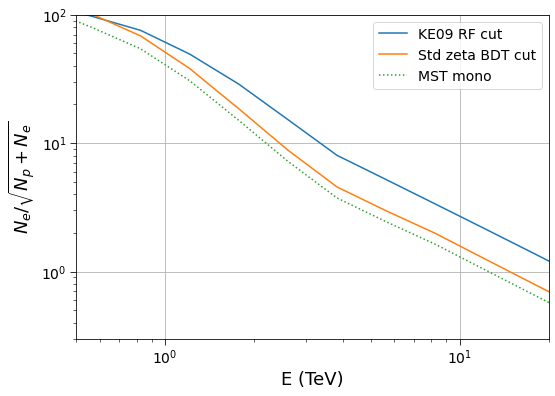

In [297]:
add_mst = 1

plt.figure()
#plt.loglog(E_KE, Q_KE_est, label='Egberts est (2009)')
#plt.loglog(E_KE, Q_KE, label='Egberts obs (2009)')
plt.loglog(Ec, Q_KE_est_1000, label='KE09 RF cut')
#plt.loglog(Ec, Q_MK, label='Kraus (2018)')
plt.loglog(Ec, Q_BDT, label='Std zeta BDT cut')
#plt.loglog(Ec, Q0, label='HESS no rejection')
#plt.loglog(Ec, Q_calet, ls='--', label='CALET expect')

if add_mst:
    plt.loglog(Ec, Q_mst, ls=':', label='MST mono') # 
else:
    plt.loglog(Ec, Q_dampe, ls='--', label='DAMPE expect') # 
    



plt.xlabel('E (TeV)')
plt.ylabel('${N_e}/{\sqrt{N_{p} + N_{e}}}$')
plt.legend()
plt.xlim(0.5, 20)
plt.ylim(0.3, 100)
plt.grid()
#plt.title('Signal to noise ratio')

if save_plots:
    if add_mst:
        fn = plots_folder + 'Q_factor_mst.pdf'
    else:
        fn = plots_folder + 'Q_factor.pdf'
    print('save plot to file:')
    print(fn)
    plt.savefig(fn)

Save figure to file:
../plots/electrons_protons.pdf


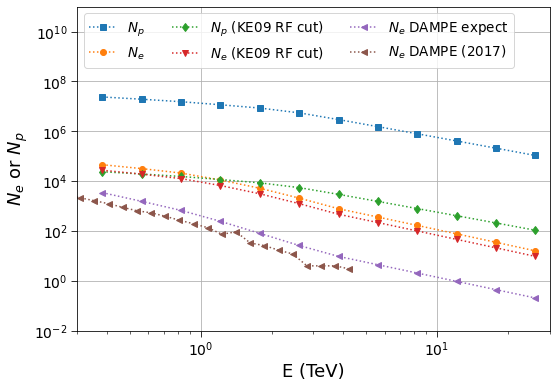

In [296]:
plt.figure()

plt.loglog(Ec, Np0_KE, ls=':', marker='s', label='$N_p$')
plt.loglog(Ec, Ne0_KE, ls=':', marker='o', label='$N_e$')


plt.loglog(Ec, Rp_KE*Np0_KE, ls=':', marker='d', label='$N_p$ (KE09 RF cut)')
plt.loglog(Ec, Re_KE*Ne0_KE, ls=':', marker='v', label='$N_e$ (KE09 RF cut)')

if 0:
    plt.loglog(Ec, Rp_MK*Np0, ls=':', marker='<', label='$N_p$ (Kraus 2018)')
    plt.loglog(Ec, Re_MK*Ne0, ls=':', marker='>', label='$N_e$ (Kraus 2018)')
else:
    plt.loglog(Ec, Ne_dampe, ls=':', marker='<', label='$N_e$ DAMPE expect')
    plt.loglog(Ec_dampe, Ne_dampe_obs, ls=':', marker='<', label='$N_e$ DAMPE (2017)')
    #plt.loglog(Ec, Ne_calet, ls=':', marker='>', label='$N_e$ CALET expect')
    
plt.grid()
plt.rcParams['legend.fontsize'] -= 0.5
plt.legend(loc='upper left', ncol=3)

plt.xlabel('E (TeV)')
plt.ylabel('$N_e$ or $N_p$')
plt.ylim(1.e-2, 1.e11)
#plt.title('Electon and proton numbers for H.E.S.S.');
plt.xlim(0.3, 30)

if save_plots:
    fn = plots_folder + 'electrons_protons.pdf'
    print('Save figure to file:')
    print(fn)
    plt.savefig(fn)
plt.rcParams['legend.fontsize'] += 0.5

In [281]:
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

# Plot fluxes

In [282]:
# Kathrin Egbert's thesis points
fn = '../data/Kathrin_Egberts_thesis_Figure3.23.csv'
KE_data_flux = pandas.read_csv(fn, comment='#')

TeV2GeV = 1000.
Ec_KE_flux = KE_data_flux['Ecenter'] / TeV2GeV
KE_E3dNdE = KE_data_flux['E3Flux'] / TeV2GeV**2
KE_E3dNdE_err_up = KE_data_flux['E3Flux_err_up'] / TeV2GeV**2
KE_E3dNdE_err_up = KE_E3dNdE_err_up - KE_E3dNdE
KE_E3dNdE_err_down = KE_data_flux['E3Flux_err_down'] / TeV2GeV**2
KE_E3dNdE_err_down = KE_E3dNdE - KE_E3dNdE_err_down


# HESS 2017 ICRC points
fn = '../data/HESS_CRe_SOM_ICRC_2017.csv'
ICRC_data_flux = pandas.read_csv(fn, comment='#')
Ec_ICRC = ICRC_data_flux['Ecenter']
E3dNdE_ICRC = ICRC_data_flux['E3dNdE'] / TeV2GeV**2
E3dNdE_ICRC_err = ICRC_data_flux['E3dNdE_err_up'] / TeV2GeV**2
E3dNdE_ICRC_err = np.abs(E3dNdE_ICRC_err - E3dNdE_ICRC)



# HESS 2008 points
fn = '../data/HESS_0811.3894_CRe.csv'
HESS_data_flux = pandas.read_csv(fn, comment='#')
Ec_HESS = HESS_data_flux['Ecenter'] / TeV2GeV
E3dNdE_HESS = HESS_data_flux['E3dNdE'] / TeV2GeV**2
E3dNdE_HESS_err = HESS_data_flux['E3dNdE_err_up'] / TeV2GeV**2
E3dNdE_HESS_err = np.abs(E3dNdE_HESS_err - E3dNdE_HESS)


In [283]:
kob_fns.keys()

dict_keys([4, 5])

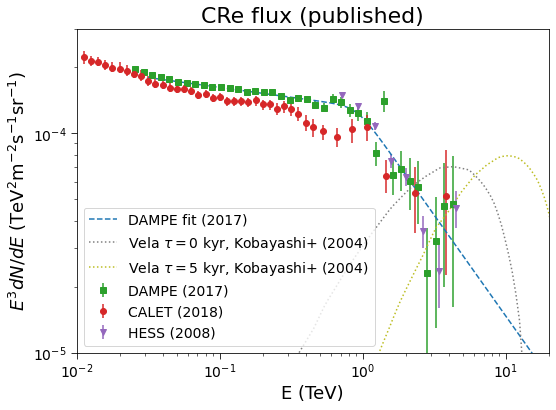

In [284]:
kob_titles = {4: r'Vela $\tau = 0$ kyr, Kobayashi+ (2004)',
              5: r'Vela $\tau = 5$ kyr, Kobayashi+ (2004)',}
plt.figure()
Ec_plot = np.logspace(-1.5, 1.5, 100)
plt.loglog(Ec_plot, Ec_plot**3 * CRe_dNdE_dampe(Ec_plot), ls='--', color=colors[0],
           label='DAMPE fit (2017)')
plt.errorbar(Ec_dampe, Ec_dampe**3 * dampe_dNdE, Ec_dampe**3 * dampe_dNdE_err, 
             ls='', marker='s', color=colors[2], label='DAMPE (2017)')
plt.errorbar(Ec_calet, Ec_calet**3 * calet_dNdE, 
             [Ec_calet**3 * calet_dNdE_err_low, Ec_calet**3 * calet_dNdE_err_high], 
             ls='', marker='o', color=colors[3], label='CALET (2018)')
plt.errorbar(Ec_HESS, E3dNdE_HESS, E3dNdE_HESS_err, 
             ls='', marker='v', color=colors[4], label='HESS (2008)')

if 1:
    Es_kob = np.logspace(-1, 1.5, 100)
    for i in [4, 5]:
        plt.loglog(Es_kob, kob_fns[i](Es_kob), ls=':', color=colors[i + 3], 
                   label=kob_titles[i])


plt.legend(loc='lower left')

plt.xlabel('E (TeV)')
plt.ylabel('$E^3 dN/dE\ ({\\rm TeV^2 m^{-2} s^{-1} sr^{-1}})$')
plt.title('CRe flux (published)')
plt.xlim(1.e-2, 20)
plt.ylim(1.e-5, 3.e-4)

if save_plots:
    plt.savefig(plots_folder + 'CRe_flux_published.pdf')

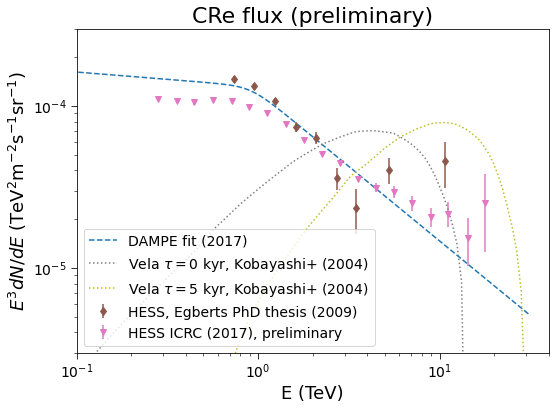

In [285]:
plt.figure()
Ec_plot = np.logspace(-1.5, 1.5, 100)
plt.loglog(Ec_plot, Ec_plot**3 * CRe_dNdE_dampe(Ec_plot), ls='--', color=colors[0],
           label='DAMPE fit (2017)')
#plt.loglog(Ec_plot, Ec_plot**3 * CRe_dNdE_dampe_hard(Ec_plot), ls='-.', color=colors[1], 
#           label='DAMPE fit (2017) + hardening')
#plt.errorbar(Ec_dampe, Ec_dampe**3 * dampe_dNdE, Ec_dampe**3 * dampe_dNdE_err, 
#             ls='', marker='s', label='DAMPE (2017)')
plt.errorbar(Ec_KE_flux, KE_E3dNdE, [KE_E3dNdE_err_down, KE_E3dNdE_err_up], 
             ls='', marker='d', color=colors[5], label='HESS, Egberts PhD thesis (2009)')
plt.errorbar(Ec_ICRC, E3dNdE_ICRC, E3dNdE_ICRC_err, 
             ls='', marker='v', color=colors[6], label='HESS ICRC (2017), preliminary')

if 1:
    Es_kob = np.logspace(-1, 1.5, 100)
    for i in [4, 5]:
        plt.loglog(Es_kob, kob_fns[i](Es_kob), ls=':', color=colors[i + 3], 
                   label=kob_titles[i])


plt.legend(loc='lower left')

plt.xlabel('E (TeV)')
plt.ylabel('$E^3 dN/dE\ ({\\rm TeV^2 m^{-2} s^{-1} sr^{-1}})$')
plt.title('CRe flux (preliminary)');
plt.xlim(1.e-1, 40)
plt.ylim(3.e-6, 3.e-4)

if save_plots:
    plt.savefig(plots_folder + 'CRe_flux_unpublished.pdf')

In [286]:
CRe_dNdE_dampe(3)

1.6473382462499286e-06

In [287]:
f10_e = CRe_dNdE(10.) * 10/2.92
N10_e = Aeff_func(10.) * t * Om * f10_e
print(N10_e)

4092.7967309063893


In [288]:
f10_p = CRp_dNdE(10.) * 10/1.7
N10_p = Aeff_func(10.) * t * Om * f10_p
print('%.2e' % N10_p)

3.54e+07


In [289]:
CRp_dNdE(10.)*Aeff_func(10.) * t * Om/1.e6

6.015393922328229

In [290]:
dE, 10/1.7

(array([ 0.14793112,  0.21713319,  0.31870793,  0.46779927,  0.68663542,
         1.00784297,  1.47931117,  2.17133186,  3.18707931,  4.67799268,
         6.86635422, 10.0784297 ]),
 5.882352941176471)

In [291]:
2.8/1.7*10**0.1

2.0735242076609812

In [292]:
780 * 24 / 15811

1.1839858326481563

In [293]:
#qf_ke1 = 0.6 / np.sqrt(0.001)
qf_ke2 = 0.96 / np.sqrt(0.0072)
#qf_so1 = 0.84 / np.sqrt(0.01)
qf_so2 = 0.84 / np.sqrt(0.03)
qf_mst = 0.22 / np.sqrt(0.002)
print(qf_ke2/2, qf_so2, qf_mst)

5.65685424949238 4.849742261192856 4.919349550499537
